## Scikit trading sample with pipeline

In [18]:
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib
# plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10, 6)

from sklearn.preprocessing import LabelBinarizer
from util_functions import *

days_predict = 1
test_size = 0.4

etfToSymbol = {

    'momentum': 'MTUM',
    'quality': 'QUAL',
    'value': 'VLUE',
}
symbols = list(etfToSymbol.values())

## Import dataset

In [3]:
dataDict = excel_to_dataDict('historical_data_robotrader.xlsx')
#using framework https://github.com/tradeasystems/tradeasystems_connector
# dataDict=import_data_from_fw(symbols)

## Prepare dataset
### Input: adding features to input
### Target: get return of future days to predict

In [5]:
targetMatrix = get_target(dataDict=dataDict, symbols=list(etfToSymbol.values()), days_predict=days_predict)
inputMatrix = get_input(dataDict=dataDict)
# Clean nan data
inputMatrixClean = inputMatrix.dropna(axis=1)
inputMatrixClean.fillna(0,inplace=True)
targetMatrix = targetMatrix.T[inputMatrixClean.index].T
inputMatrixClean.head()

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


,EUR,MTUM,QUAL,TNX,VLUE,spy,high_EUR,high_MTUM,high_QUAL,high_TNX,...,open_QUAL,open_TNX,open_VLUE,open_spy,low_EUR,low_MTUM,low_QUAL,low_TNX,low_VLUE,low_spy
2013-07-18,1.313925,50.613834,46.051929,2.534,48.876106,152.258530,1.31510,54.110001,50.230000,2.542,...,50.230000,2.482,54.730000,168.309998,1.30809,53.889999,50.150002,2.480,54.660000,168.199997
2013-07-19,1.314265,50.838329,45.693802,2.491,48.786808,152.529007,1.31548,54.389999,50.599998,2.535,...,50.599998,2.535,54.630001,168.520004,1.31276,54.279999,49.759998,2.484,54.630001,168.309998
2013-07-22,1.321250,50.903797,45.914188,2.488,48.920753,152.826553,1.32304,55.049999,50.480000,2.494,...,50.480000,2.475,54.990002,169.410004,1.31638,54.340000,49.950001,2.465,54.779999,169.009995
2013-07-23,1.320590,50.819630,45.840729,2.516,48.920753,152.501953,1.32564,54.500000,50.389999,2.533,...,50.389999,2.522,54.779999,169.800003,1.31907,54.270000,49.900002,2.496,54.779999,169.050003
2013-07-24,1.322885,50.641895,45.776447,2.588,48.920753,151.942917,1.32401,54.480000,49.849998,2.626,...,49.799999,2.556,54.779999,169.789993,1.31661,54.020000,49.799999,2.554,54.779999,168.179993


In [6]:
targetMatrix.head()

2013-07-18    0.0
2013-07-19    1.0
2013-07-22    2.0
2013-07-23    2.0
2013-07-24    0.0
dtype: float64

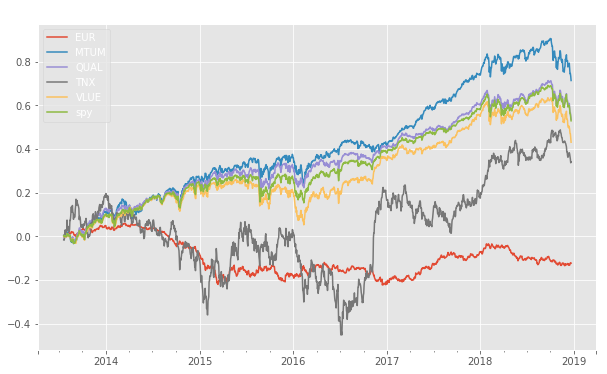

In [19]:
returnsAll = get_returns(dataDict, days_predict, plot=True)

### Split dataset

In [7]:
x_train, x_test = train_test_split(inputMatrixClean.fillna(0), test_size=test_size, shuffle=False)
y_train, y_test = train_test_split(targetMatrix.fillna(0), test_size=test_size, shuffle=False)

print('input have %d features' % (len(inputMatrixClean.columns)))
print('train  have %d samples \ntest %d samples' % (len(x_train), len(x_test)))

input have 30 features
train  have 849 samples 
test 567 samples


# 1 - SVC : Support vector classifier
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [8]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
imputer = preprocessing.Imputer()  # drop columns with nans
scaler = preprocessing.StandardScaler()
# pca = PCA(kernel="rbf", n_components=5, n_jobs=4)
classifier = SVC(gamma=2, C=1)

pipelineObject = Pipeline([('imputer', imputer),
                           ('scaler', scaler),
                           #('pca', pca),
                           ('classifier', classifier)])


pipelineObject.fit(x_train.dropna(),y_train)
train_accuracy= hamming_score(y_train, pipelineObject.predict(x_train))
test_accuracy= hamming_score(y_test, pipelineObject.predict(x_test))
#% train hamming_score =0.887   test hamming_score =0.501
print('train hamming_score =%.3f   test hamming_score =%.3f'%(train_accuracy,test_accuracy))

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


train hamming_score =0.947   test hamming_score =0.490


# 2- Decision Tree classifier
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [9]:
from sklearn.tree import DecisionTreeClassifier
imputer = preprocessing.Imputer()  # drop columns with nans
scaler = preprocessing.StandardScaler()
# pca = PCA(kernel="rbf", n_components=5, n_jobs=4)
classifier = DecisionTreeClassifier()

pipelineObject = Pipeline([('imputer', imputer),
                           ('scaler', scaler),
                           #('pca', pca),
                           ('classifier', classifier)])


pipelineObject.fit(x_train.dropna(),y_train)
train_accuracy= hamming_score(y_train, pipelineObject.predict(x_train))
test_accuracy= hamming_score(y_test, pipelineObject.predict(x_test))
# train hamming_score =1.000   test hamming_score =0.529
print('train hamming_score =%.3f   test hamming_score =%.3f'%(train_accuracy,test_accuracy))

train hamming_score =0.999   test hamming_score =0.496


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# 3- Xgboost classifier
https://xgboost.readthedocs.io/en/latest/

In [10]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
imputer = preprocessing.Imputer()  # drop columns with nans
scaler = preprocessing.StandardScaler()
# pca = PCA(kernel="rbf", n_components=5, n_jobs=4)
classifier = XGBClassifier()

pipelineObject = Pipeline([('imputer', imputer),
                           ('scaler', scaler),
                           #('pca', pca),
                           ('classifier', classifier)])


pipelineObject.fit(x_train,y_train)
train_accuracy= hamming_score(y_train, pipelineObject.predict(x_train))
test_accuracy= hamming_score(y_test, pipelineObject.predict(x_test))
# train hamming_score =0.830   test hamming_score =0.483
print('train hamming_score =%.3f   test hamming_score =%.3f' % (train_accuracy,test_accuracy))

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


train hamming_score =0.841   test hamming_score =0.483


#### backtest xgboost prediction

In [20]:
# %% probabilistic = weight => backtest

output_train = pipelineObject.predict_proba(x_train)
output_test = pipelineObject.predict_proba(x_test)

In [23]:
returns_train = returnsAll.T[x_train.index].T[symbols]
returns_test = returnsAll.T[x_test.index].T[symbols]
backtest_train_returns = returns_train * output_train
backtest_test_returns = returns_test * output_test

backtest_total = backtest_train_returns.append(backtest_test_returns).dropna()
test_date = returns_test.index[0]

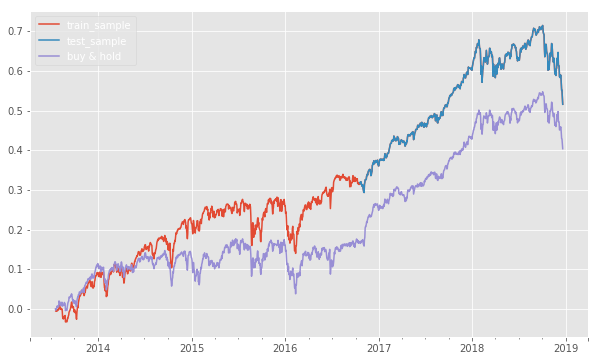

In [24]:
pnl_total = backtest_total.sum(axis=1).cumsum()
pnl_total.plot()
pnl_total[test_date:].plot()

benchmark_total = returnsAll / returnsAll.shape[1]
pnl_benchmark = benchmark_total.sum(axis=1).cumsum()
pnl_benchmark.plot()
plt.legend(['train_sample', 'test_sample', 'buy & hold'])
plt.show()

### backtest with commissions

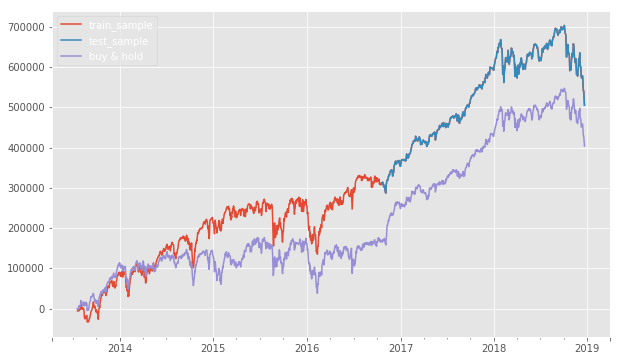

In [25]:
commission_average_etf = 0.44/100
basic_fee = 2
capital=1000000#play with capital to get min balance
#%%%
backtest_train_returns_commission = (backtest_train_returns)*capital - basic_fee - (backtest_train_returns)*capital*commission_average_etf
backtest_test_returns_commission = (backtest_test_returns)*capital - basic_fee - (backtest_test_returns)*capital*commission_average_etf


backtest_total_commission = backtest_train_returns_commission.append(backtest_test_returns_commission).dropna()
plt.close()
pnl_total_commission = backtest_total_commission.sum(axis=1).cumsum()
pnl_total_commission.plot()
pnl_total_commission[test_date:].plot()
plt.close()
pnl_total_commission.plot()
pnl_total_commission[test_date:].plot()

benchmark_total = (returnsAll / returnsAll.shape[1])*capital
pnl_benchmark = benchmark_total.sum(axis=1).cumsum()
pnl_benchmark.plot()
plt.legend(['train_sample', 'test_sample', 'buy & hold'])